# PyTorch MNIST tutorial

Demonstration of the MNIST CNN from pyTorch examples.

Adapted to include tensorboard support by jimmy.engstrom@sony.com

2020-05-20

In [1]:
# Basic general ML imports
import numpy as np
import seaborn as sns
import argparse

# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import StepLR


You need to run tensorboard on the command line. Start the a new prompt and navigate to the project directory. Then run
```
conda activate mnistlab
tensorboard --logdir runs
```


In [2]:
# Our tensorboard logger
# Writer will output to ./runs/ directory by default
# You NEED to run tensorboard on the commandline:
writer = SummaryWriter()

## CNN

Below is an example of a CNN (not exactly the one we are using).
These usually consists of convolutional layers, pooling layers and fully connected layers.
The further our information is piped through the architecture, the higher level our features are. In the end, we only have 10 different outputs, one for each digit.


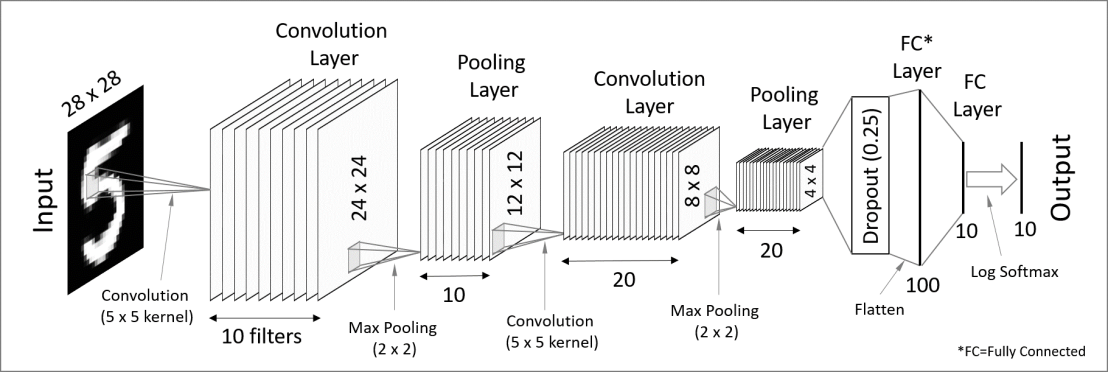

In [3]:
# Network definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output
    


In [4]:
def train(args, model, device, train_loader, optimizer, epoch, tb_writer):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            tb_writer.add_scalar("Train loss", loss.item(), epoch)

In [5]:
def test(model, device, test_loader, tb_writer):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    tb_writer.add_scalar("Test loss", correct / len(test_loader.dataset))

In [6]:
parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                    help='input batch size for training (default: 64)')
parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                    help='input batch size for testing (default: 1000)')
parser.add_argument('--epochs', type=int, default=14, metavar='N',
                    help='number of epochs to train (default: 14)')
parser.add_argument('--lr', type=float, default=1.0, metavar='LR',
                    help='learning rate (default: 1.0)')
parser.add_argument('--gamma', type=float, default=0.7, metavar='M',
                    help='Learning rate step gamma (default: 0.7)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')

parser.add_argument('--save-model', action='store_true', default=False,
                    help='For Saving the current Model')


_StoreTrueAction(option_strings=['--save-model'], dest='save_model', nargs=0, const=True, default=False, type=None, choices=None, help='For Saving the current Model', metavar=None)

In [7]:
args = parser.parse_args(["--epochs","2", "--log-interval", "100", "--no-cuda"])
# args = parser.parse_args(["--epochs","2", "--log-interval", "100"])

In [8]:
use_cuda = not args.no_cuda and torch.cuda.is_available()
torch.manual_seed(args.seed)
device = torch.device("cuda" if use_cuda else "cpu")

In [9]:
model = Net().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=args.lr)

In [10]:

train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=args.batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=args.test_batch_size, shuffle=True)


images, labels = next(iter(train_loader))

grid = make_grid(images)
writer.add_image('images', grid, 0)
if use_cuda:
    writer.add_graph(model.cuda(), images)
else:
    writer.add_graph(model, images)
writer.close()

100.1%

Extracting ../data\MNIST\raw\train-images-idx3-ubyte.gz to ../data\MNIST\raw


113.5%

Extracting ../data\MNIST\raw\train-labels-idx1-ubyte.gz to ../data\MNIST\raw


100.4%

Extracting ../data\MNIST\raw\t10k-images-idx3-ubyte.gz to ../data\MNIST\raw


180.4%..\torch\csrc\utils\tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


Extracting ../data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ../data\MNIST\raw
Processing...
Done!


In [11]:
scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)
writer = SummaryWriter()
for epoch in range(1, args.epochs + 1):
    train(args, model, device, train_loader, optimizer, epoch, writer)
    test(model, device, test_loader, writer)
    scheduler.step()
    



Train Epoch: 1 [0/60000 (0%)]	Loss: 2.311288
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.480107
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.228634
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.110498
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.140374
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.170126
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.140560
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.104849
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.070518
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.108714

Test set: Average loss: 0.0623, Accuracy: 9803/10000 (98%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.103234
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.038672
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.019875
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.048176
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.103673
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.048912
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.024070
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.017531
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.057498
T

In [12]:
torch.save(model, "mymodel.pt")

C:\Users\SEEngstJi\Miniconda3\envs\mnistlab\lib\site-packages\torch\serialization.py:401: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "
